In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'driver-drowsiness-dataset-ddd:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2195166%2F3667213%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240617%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240617T120223Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D66d99560e9e265a9e1bb7499703e3bac4fe4e35d43c8cf6c3afec010313a84cb8302bbdbc8fe401defc76e26afd8719811c22edbd54e884f29d7acdc958b44b2290d9c55bd9e08ed24449d70c43f17dc3b35f34333bf37e9371c854df9434dcf57cfe34f6b77cb0112d8e9b252133580c11d9e3c6bc2fd938e6f00326ff69c6fdb1bd66e52fe1da3b733caf79bb570a1aa214ec8c445dc6496075ce7ca5491616a7cb089c9c917e6ad2dfb025cd852020f18d71b7143824431abee0f0ea5fd793d08110681a7ea47a7e07e8120efab7e3eab0b6a419cddb632899fe08e822c583b831557deac53ffb51ebe574d4c583f7b0ef6fbb8682d051ef3258fe8949ab5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2771981638 bytes downloaded
Downloaded and uncompressed: driver-drowsiness-dataset-ddd
Data source import complete.


In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/i0702.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/d0824.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/x1026.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/j0624.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/y1346.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/za0817.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/zc0010.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/za0013.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/k0155.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DD

### Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

tf.random.set_seed(3)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD

### Loading the Dataset

In [4]:
!pip install split-folders

In [5]:
import splitfolders

data_dir = '/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)'
output_dir = '/kaggle/working/splitted_Data'
splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05))

Copying files: 41793 files [00:32, 1298.63 files/s]


### Data Preprocessing

In [6]:
train_dir = "/kaggle/working/splitted_Data/train"
test_dir = "/kaggle/working/splitted_Data/test"
val_dir = "/kaggle/working/splitted_Data/val"

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_images = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

val_images = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

test_images = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)

Found 33434 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.


In [8]:
train_class_indices = train_images.class_indices
test_class_indices = test_images.class_indices
val_class_indices = val_images.class_indices

print(train_class_indices,val_class_indices,test_class_indices)

{'Drowsy': 0, 'Non Drowsy': 1} {'Drowsy': 0, 'Non Drowsy': 1} {'Drowsy': 0, 'Non Drowsy': 1}


In [9]:
train_class_labels = train_images.classes
test_class_labels = test_images.classes
val_class_labels = val_images.classes

print(train_class_labels,val_class_labels,test_class_labels)

[0 0 0 ... 1 1 1] [0 0 0 ... 1 1 1] [0 0 0 ... 1 1 1]


In [10]:
from collections import Counter

train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

In [11]:
print(train_class_counts)
print(val_class_counts)
print(test_class_counts)

Counter({0: 17878, 1: 15556})
Counter({0: 3352, 1: 2916})
Counter({0: 1118, 1: 973})


### Data Visualization

Pixels of the first image after Normalization: 

[[[0.8745099  0.8941177  0.8470589 ]
  [0.8745099  0.8862746  0.854902  ]
  [0.87843144 0.89019614 0.8588236 ]
  ...
  [0.87843144 0.87843144 0.8470589 ]
  [0.8745099  0.87843144 0.85098046]
  [0.87843144 0.882353   0.854902  ]]

 [[0.8745099  0.8941177  0.85098046]
  [0.8745099  0.89019614 0.854902  ]
  [0.87843144 0.89019614 0.8588236 ]
  ...
  [0.8705883  0.8705883  0.83921576]
  [0.8745099  0.87843144 0.85098046]
  [0.87843144 0.882353   0.854902  ]]

 [[0.87843144 0.8941177  0.8588236 ]
  [0.87843144 0.89019614 0.8588236 ]
  [0.87843144 0.882353   0.854902  ]
  ...
  [0.8705883  0.8705883  0.8352942 ]
  [0.87843144 0.882353   0.854902  ]
  [0.87843144 0.882353   0.854902  ]]

 ...

 [[0.42352945 0.41960788 0.4156863 ]
  [0.41960788 0.4156863  0.41176474]
  [0.4156863  0.41176474 0.40784317]
  ...
  [0.5372549  0.5176471  0.5529412 ]
  [0.5176471  0.49411768 0.5254902 ]
  [0.4666667  0.4431373  0.47450984]]

 [[0.4156863  0.41176474 

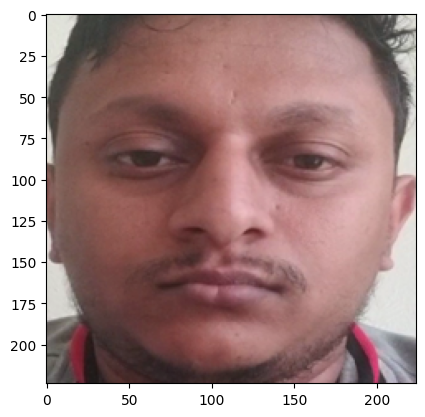

In [12]:
images, labels = next(train_images)
print(f"Pixels of the first image after Normalization: \n\n{images[0]}") #print pixels of the first img
plt.imshow(images[0])
plt.show()

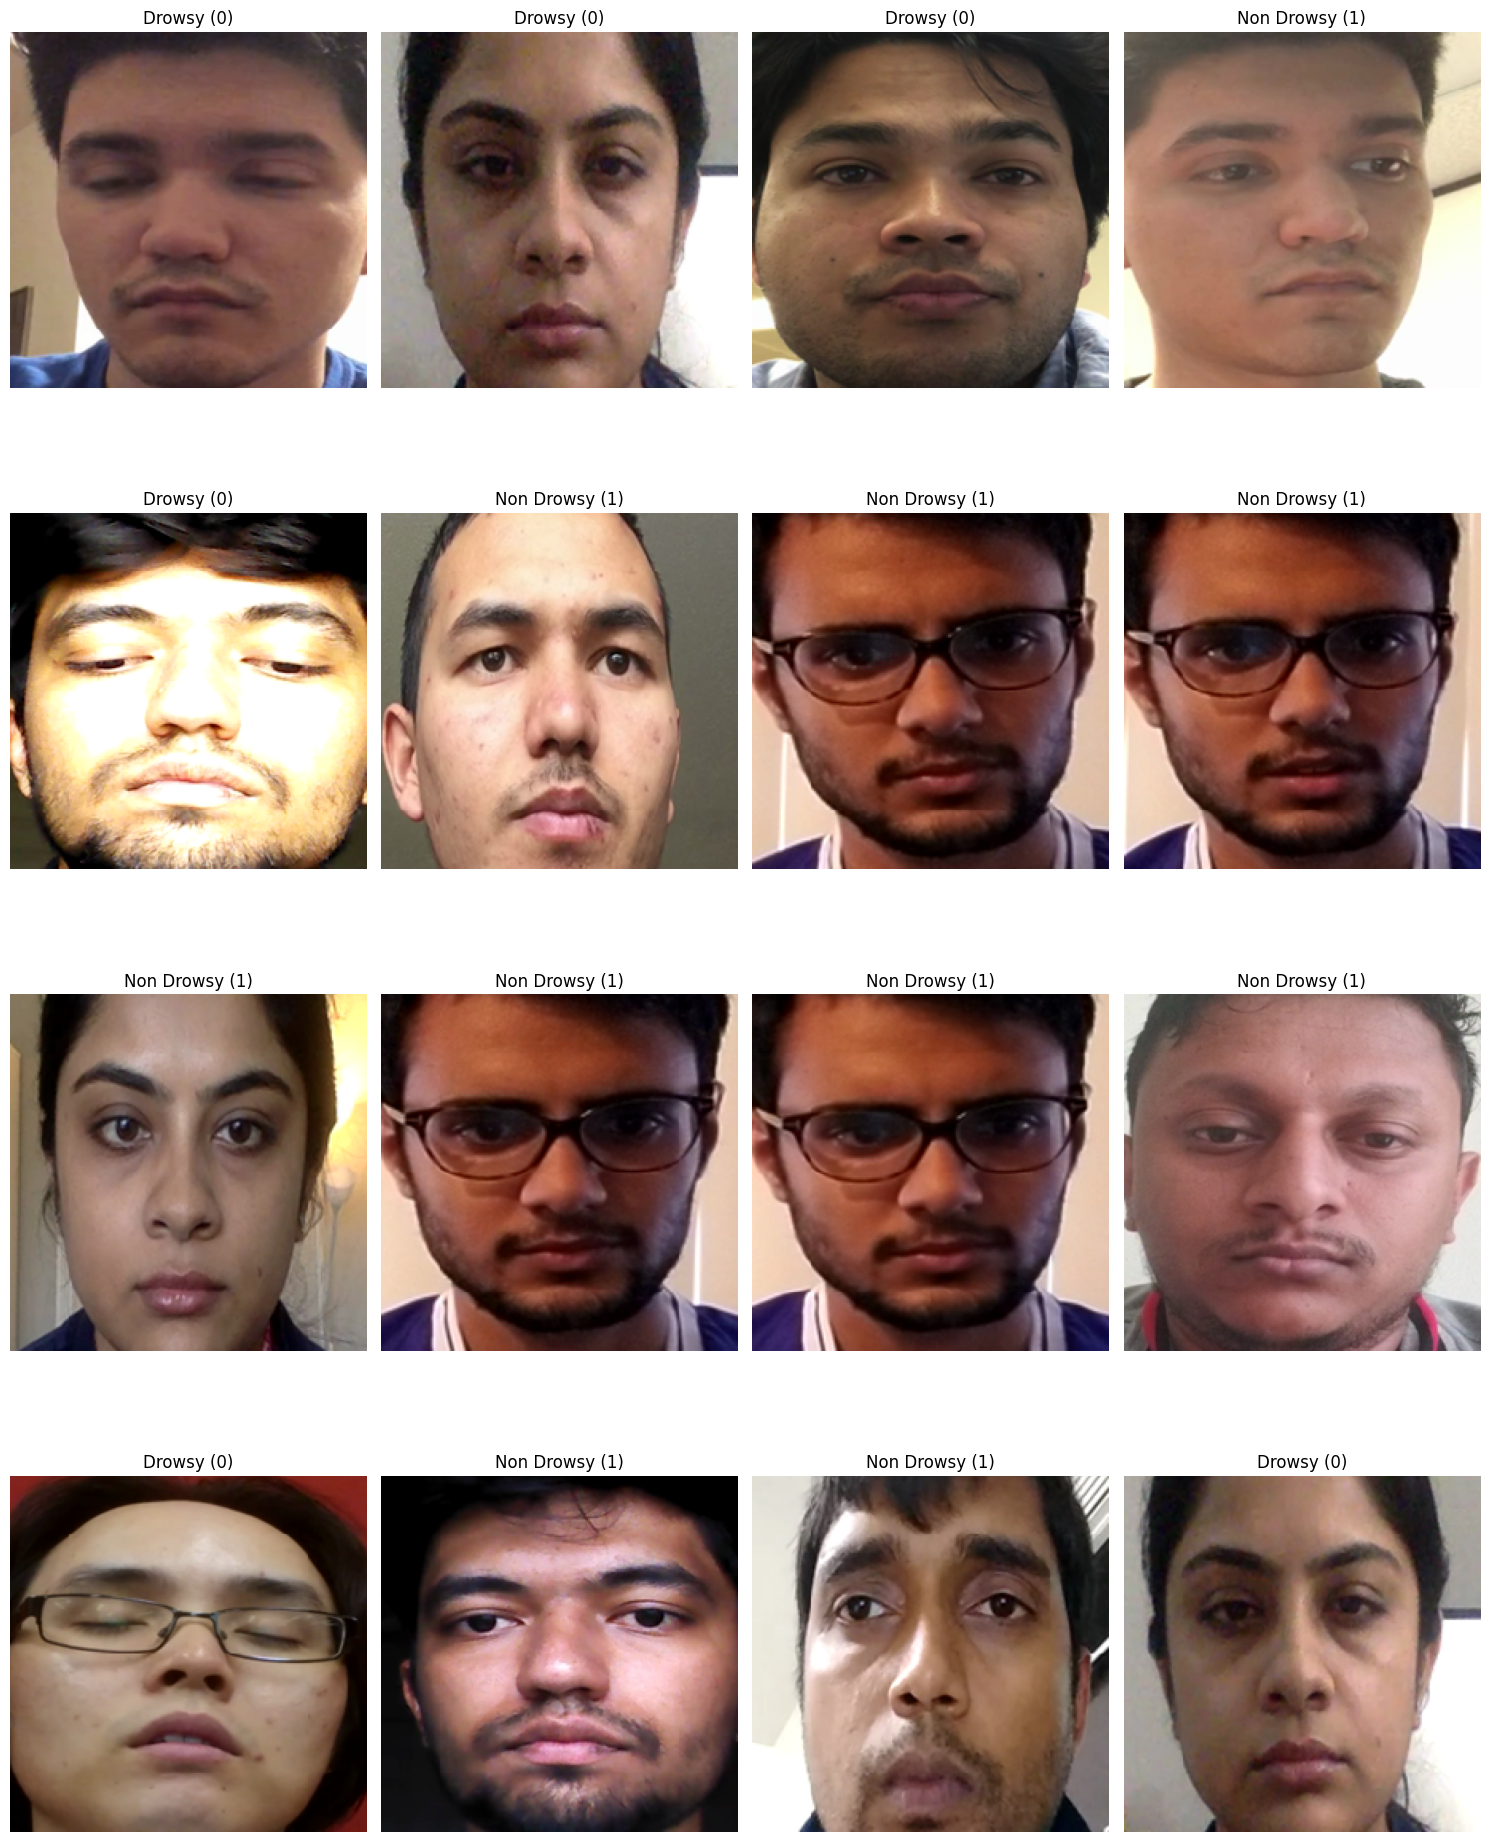

In [13]:
fig, axes = plt.subplots(4, 4, figsize=(15, 20))
class_indices = train_images.class_indices

for i in range(4):
    images, labels = next(train_images)
    for j in range(4):
        ax = axes[i, j]
        ax.imshow(images[j])
        ax.axis('off')
        label = int(labels[j])
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()

### Model Training

In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Load pre-trained MobileNetV2 model without including the top (fully connected) layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model (optional)
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
x = Dense(512, activation='relu')(x)  # Fully connected layer with 512 units
predictions = Dense(2, activation='softmax')(x)  # Output layer with 2 units for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [15]:
history = model.fit(
   train_images,
    epochs=5,
    validation_data=val_images,
    batch_size=32
)

Epoch 1/5
2090/2090 [==============================] - 190s 88ms/step - loss: 0.0374 - accuracy: 0.9864 - val_loss: 0.0026 - val_accuracy: 0.9989
Epoch 2/5
2090/2090 [==============================] - 153s 73ms/step - loss: 0.0088 - accuracy: 0.9974 - val_loss: 0.0027 - val_accuracy: 0.9987
Epoch 3/5
2090/2090 [==============================] - 155s 74ms/step - loss: 0.0043 - accuracy: 0.9986 - val_loss: 0.0027 - val_accuracy: 0.9990
Epoch 4/5
2090/2090 [==============================] - 170s 82ms/step - loss: 0.0035 - accuracy: 0.9986 - val_loss: 0.0034 - val_accuracy: 0.9987
Epoch 5/5
2090/2090 [==============================] - 172s 82ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0023 - val_accuracy: 0.9994


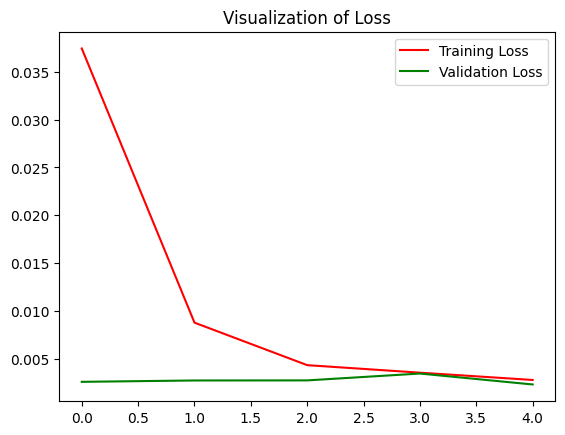

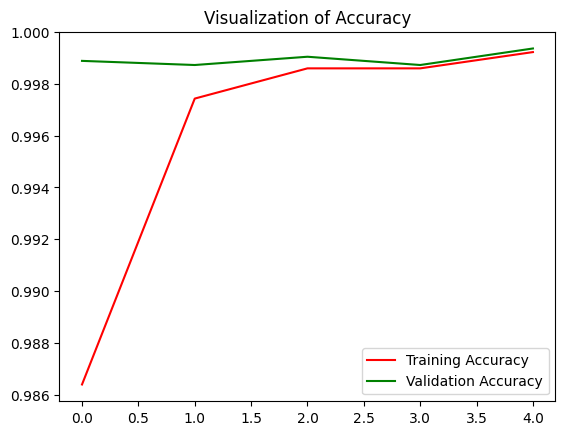

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss,'r',label='Training Loss')
plt.plot(val_loss,'g',label='Validation Loss')
plt.title("Visualization of Loss")
plt.legend()

plt.figure()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(acc,'r',label='Training Accuracy')
plt.plot(val_acc,'g',label='Validation Accuracy')
plt.title("Visualization of Accuracy")
plt.legend()

### Predictions

In [17]:
loss, accuracy = model.evaluate(test_images)
print("Testing Loss:",loss)
print("Testing Accuracy: ",accuracy)

131/131 [==============================] - 9s 65ms/step - loss: 0.0119 - accuracy: 0.9981
Testing Loss: 0.011907543055713177
Testing Accuracy:  0.9980870485305786


In [18]:
y_pred = model.predict(test_images)
y_pred_labels = np.argmax(y_pred, axis=1)
y_actual = test_images.labels
conf_matrix = confusion_matrix(y_actual, y_pred_labels)
print(conf_matrix)

131/131 [==============================] - 9s 65ms/step
[[613 505]
 [509 464]]


<Axes: >

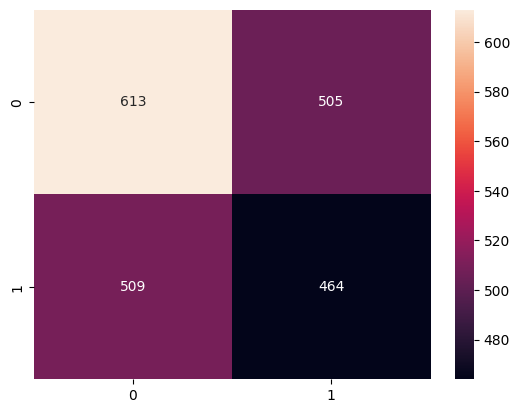

In [19]:
sns.heatmap(conf_matrix,annot=True,fmt='d')

In [20]:
report = classification_report(y_actual, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.55      0.55      0.55      1118
           1       0.48      0.48      0.48       973

    accuracy                           0.52      2091
   macro avg       0.51      0.51      0.51      2091
weighted avg       0.51      0.52      0.51      2091



In [21]:
model.export('Sleeping Detection Model')

Saved artifact at 'Sleeping Detection Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  138991048364224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138991048369856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138991048371088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138991048372320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138991048373552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138991048361056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138991048371616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138991049049536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138991049051824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138991049053056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13899104837

In [22]:
from google.colab import drive
drive.mount('/content/drive')

import shutil
shutil.make_archive('/content/Sleeping_Detection_Model', 'zip', '/content/Sleeping Detection Model')
shutil.move('/content/Sleeping_Detection_Model.zip', '/content/drive/My Drive/')

drive.flush_and_unmount()

Mounted at /content/drive
